In [3]:
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
import matplotlib.pyplot as plt

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import ast

In [7]:
import CleanTweets as ct

[nltk_data] Downloading package stopwords to /Users/Lono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Lono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
from nltk import bigrams
import itertools
import collections

In [9]:
african_names = pd.read_csv("africa_names.csv", names = ["names", "nan"])
fix_list = african_names["names"].to_list()

In [428]:
def get_wordcloud(df, text_col, title):# Generate a word cloud image
    wordcloud = WordCloud(background_color="white", width=1500, height=800).generate(' '.join(df[text_col]))

    # Display the generated image:

    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('../artefacts/' + title +'.eps', format='eps')

In [382]:
def draw_network(df, text_col, max_similarity, name):
    
    cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english') # You can define your own parameters
    X = cv.fit_transform(df[text_col])
    Xc = (X.T * X) # Cosine similarity of words

    names = cv.get_feature_names() # This are the entity names (i.e. keywords)
    df_co = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

    a = df_co.stack().reset_index()
    a.columns = ['source', 'target','value']
    a_filtered=a.loc[ (a['value'] > max_similarity) & (a['source'] != a['target']) ]


    # Build your graph
    plt.figure(figsize=(20,10))
    G=nx.from_pandas_edgelist(a_filtered, 'source', 'target')

    # Plot the network:
    # pos = graphviz_layout(G)
    plt.savefig('../artefacts/' + name +'.eps', format='eps')

    nx.draw(G, with_labels=True, node_color='orange', node_size=50, edge_color='green', linewidths=2, font_size=15)

In [383]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/
def draw_cooccur_network(df, top_n_bigrams, col, title):
    terms_bigram = [list(bigrams(doc.split())) for doc in df[col]]
    bigramsls = list(itertools.chain(*terms_bigram))
    bigram_counts = collections.Counter(bigramsls)
    bigram_df = pd.DataFrame(bigram_counts.most_common(top_n_bigrams),
                                 columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(15, 8))
    pos = nx.spring_layout(G, k=2)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=12,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.045, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.2),
                horizontalalignment='center', fontsize=13)
    plt.title(title)
    plt.savefig('../artefacts/' + title +'.eps', format='eps')
    plt.show()

# Publications

## 1. Time/volume - line chart

In [384]:
df = pd.read_csv('../data_gc/td_pulications.csv', index_col=0)

In [385]:
df['pub_year'] = df['bib'].apply(lambda x: ast.literal_eval(x)['pub_year'])
df_not_nan = df[df['pub_year']!= 'NA']

Note we lose a couple of publications because a number of them do not have publication year attached

In [386]:
#df_not_nan['pub_year'] = pd.to_datetime(df_not_nan['pub_year'])
df_not_nan['pub_year'] = df_not_nan['pub_year'].astype(int)
df_groupedby_date = df_not_nan.groupby('pub_year').count()
df_groupedby_date.reset_index(inplace=True)

/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [387]:
df_groupedby_date['count'] = df_groupedby_date['container_type']

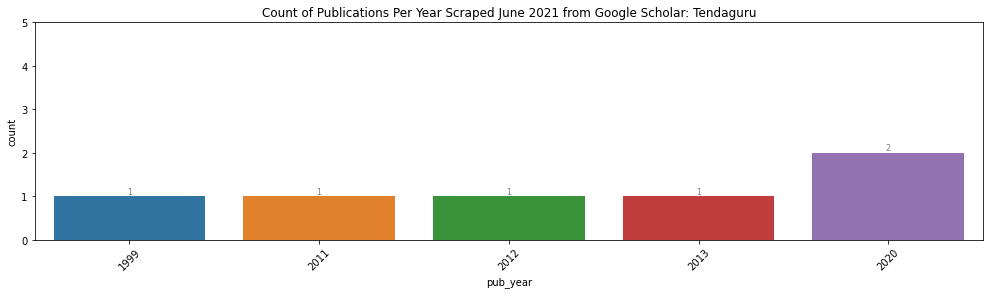

In [388]:
plt.figure(figsize=[17,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Scraped June 2021 from Google Scholar: Tendaguru')
g = sns.barplot(data=df_groupedby_date, 
             x="pub_year", 
             y="count") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,5) #To make space for the annotations

In [389]:
df_groupedby_date_2016 = df_groupedby_date[df_groupedby_date['pub_year'] > 2015]

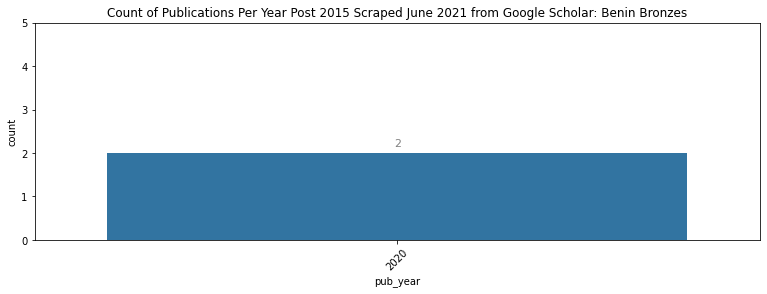

In [390]:
plt.figure(figsize=[13,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Post 2015 Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date_2016, 
             x="pub_year", 
             y="count")
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
_ = ax.set_ylim(0,5) #To make space for the annotations

## 2. Keywords - Network diagram

In [391]:
def get_abstract(x):
    try:
        return ast.literal_eval(x)['abstract']
    except KeyError:
        return ''

In [392]:
df['abstract'] = df['bib'].apply(lambda x: get_abstract(x) )
df_abs = df[df['abstract']!= '']

We lose around 100 publications because they do not have abstracts

In [393]:
df_abs = ct.clean_tweets(df_abs,'abstract','lemma_text',
                general_clean=True,lemma=True,stem=False,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 3.0785059928894043s. Use the [lemma_text] column to perform your analysis/modeling on


In [22]:
df_abs = ct.clean_tweets(df_abs,'abstract','stem_text',
                general_clean=True,lemma=False,stem=True,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 0.05427908897399902s. Use the [stem_text] column to perform your analysis/modeling on


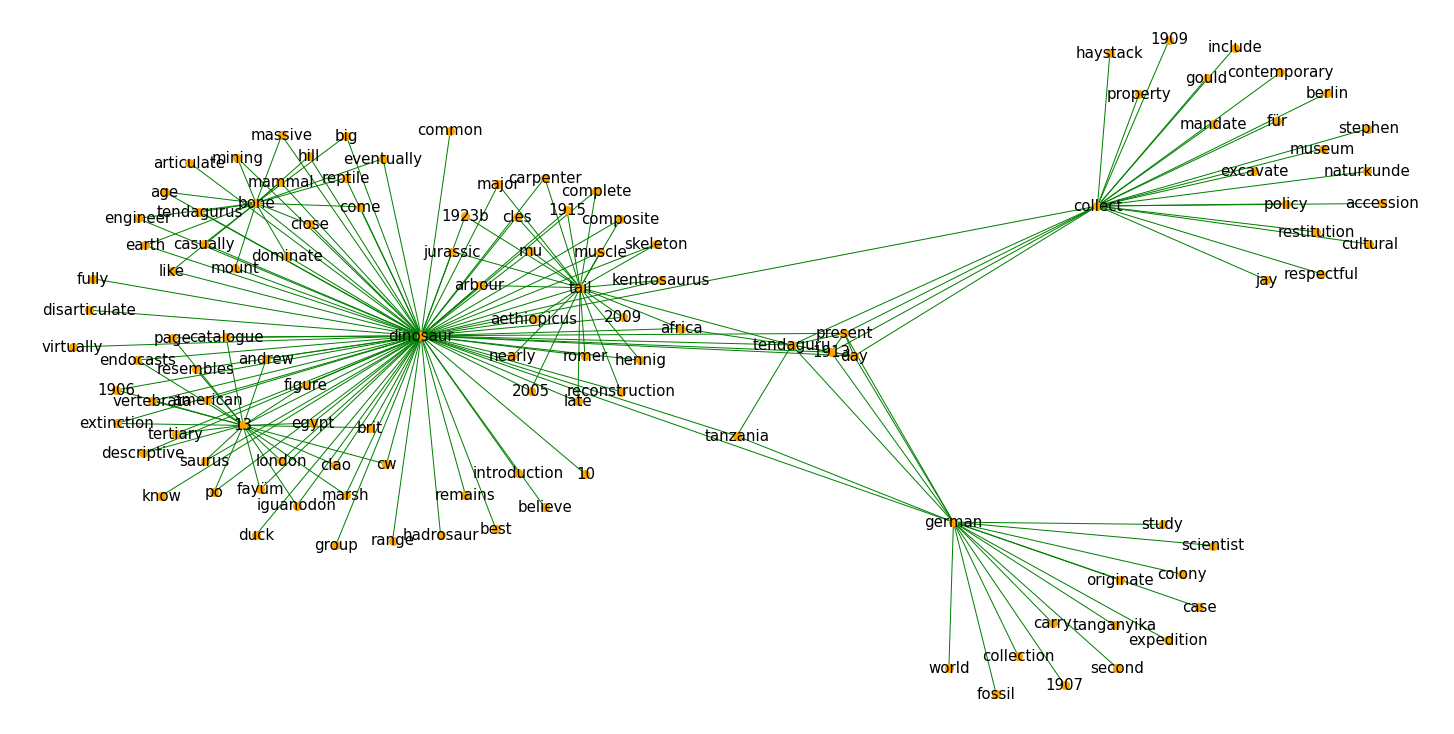

In [394]:
draw_network(df_abs, 'lemma_text', 1, 'td_abstracts_1') 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

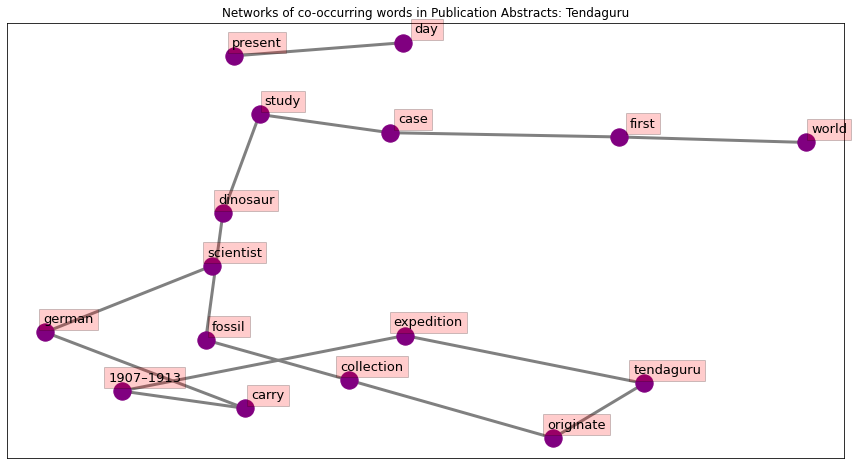

In [395]:
draw_cooccur_network(df_abs, 15,'lemma_text', 'Networks of co-occurring words in Publication Abstracts: Tendaguru')

## 3. Peoples vs citations vs ethnicity - CSV list, network diagram

In [396]:
from ethnicolr import pred_wiki_ln, pred_wiki_name

In [397]:
import unicodedata

In [398]:
def clean_name(name, surname=False):
    if surname == True:
        res = name.split(' ')[1:]
        surname = ' '.join(chars for chars in res)
        if surname == '':
            surname = name.split(' ')[0]
        name = surname
            
    name = name.lower()
    #remove phonetics
    name = ''.join((c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn'))
    return name

### Authors African vs Not

In [399]:
df = pd.read_csv('../data_gc/td_pulications.csv', index_col=0)

In [400]:
df.shape

(8, 13)

In [401]:
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])

In [402]:
df['count'] = 1
dummy = df[['author', 'count']]
dummy1 = dummy.set_index('count').author.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'author'})

In [403]:
dummy1['author'] = dummy1['author'].apply(lambda x: clean_name(x) )

In [404]:
res = dummy1.groupby('author').agg('sum').reset_index().sort_values('count',ascending=False)
res['surname'] = res['author'].apply(lambda x: clean_name(x, True))

In [405]:
preds = pred_wiki_ln(res, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


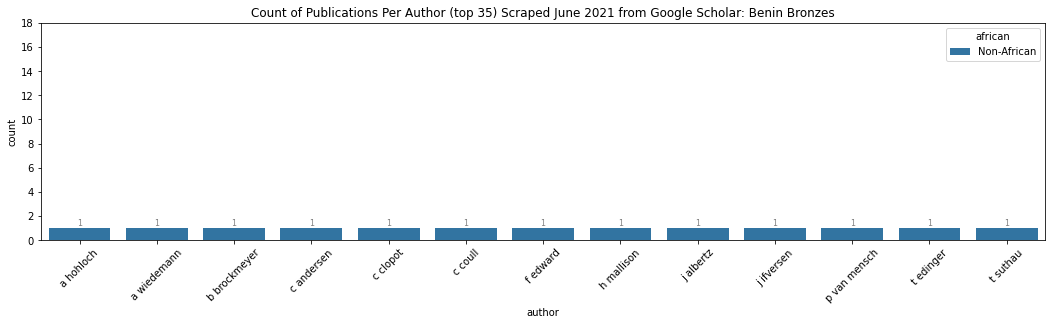

In [406]:
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Author (top 35) Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=preds[0:35], 
             x="author", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
plt.savefig('../artefacts/td_gs_pubsperauthor.eps', format='eps')
_ = ax.set_ylim(0,18) #To make space for the annotations

In [408]:
preds.to_csv('td_publications.csv')

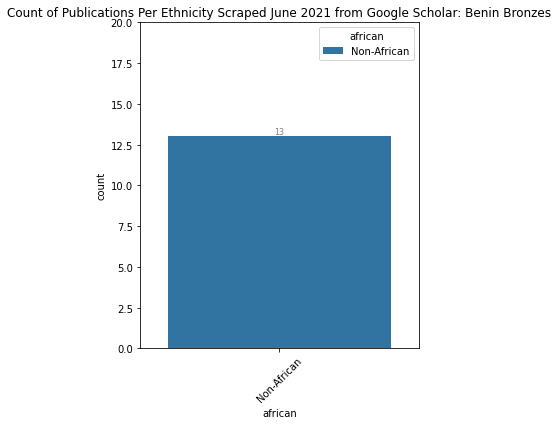

In [46]:
ratio = preds.groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Ethnicity Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,20) #To make space for the annotations

# Media 

In [409]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [410]:
df = pd.read_csv('../data_gc/td_google_content313.csv', index_col=0)
df.shape

(122, 4)

Remove pdfs

In [411]:
df = df[~df['link'].str.contains('.pdf')]
df.shape

(89, 4)

Get the remainder of pdfs

In [412]:
df_text = df[~df['text'].astype(str).str.contains("�����")]
df_text.shape

(87, 4)

Remove null texts

In [413]:
df_text = df_text[~df_text['text'].isna()]
df_text.shape

(70, 4)

Remove special links

In [414]:
# whole encyclopedia volume that mentions Tendaguru once
links_to_remove = ['https://docplayer.fr/10395969-1661-5468-vol-33-n-1-2014.html']
# also an encyclopedia volume that mentions Tendaguru once
links_to_remove.append('https://archive.org/stream/encyclopdiabri32newyrich/encyclopdiabri32newyrich_djvu.txt')
# absolutely irrelevant
links_to_remove.append('https://github.com/lopopolo/sr/blob/master/test/datadumps/experiment-7-run-4.json')

# about dinosaurs not restituion, many many words, mentions Tendaguru Formation
links_to_remove.append('https://www.science.gov/topicpages/b/bone+size+variation')

# Tendaguru does not appear
links_to_remove.append('https://worldwidescience.org/topicpages/e/early+precambrian+microfossils.html')

# lots of words Tendaguru mentioned once 
links_to_remove.append('https://geobrowser.de.dariah.eu/data/dbpedia/museum.kml')

# lots of words no restituion
links_to_remove.append('https://worldwidescience.org/topicpages/t/terrestrial+palynological+assemblages.html')

# lots of words no restitution
links_to_remove.append('https://dokumen.site/download/2012-eavp-abstracts-a5b39f10665dd5')

# too many words and has restitution only once
links_to_remove.append('https://ars.electronica.art/prix/en/jurystatement/')
links_to_remove.append('https://docplayer.net/152439676-Prize-19-s-t-arts-prix-ars-electronica-cyberarts-ars-electronica-art-technology-society.html')

# too may words mostly german
links_to_remove.append('https://mws.hypotheses.org/tag/reports/feed')

In [415]:
df_text = df_text[~df_text['link'].isin(links_to_remove)]
df_text.shape

(59, 4)

Remove videos

In [416]:
df_text = df_text[~df_text['link'].astype(str).str.contains("youtube")]
df_text.shape

(58, 4)

In [417]:
df_text['text_len'] = df_text['text'].apply(lambda x: len(x))

Remove html tags

In [418]:
df_text['text'] = df_text['text'].apply(lambda x: strip_tags(x))

#### NB: There are a lot of german articles that this analysis will miss

Remove german stop words

In [419]:
german_stop_words = stopwords.words('german')

In [420]:
df_text['text'] = df_text['text'].apply(lambda x: " ".join([item for item in x.split() if item not in german_stop_words])  )

In [421]:
df_text[df_text['text'].str.contains('schedule')].iloc[0].link

'https://www.dailynews.co.tz/news/2019-02-205c6cec953280b.aspx'

### 1. Keywords - Network diagram: Pelonomi

The green newtork diagrams are with regards to word similarity based on the texts

In [422]:
df_text = ct.clean_tweets(df_text,'text','lemma_text',
                general_clean=True,lemma=True,stem=False,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 12.852748155593872s. Use the [lemma_text] column to perform your analysis/modeling on


### The first 15 articles. This is typically the first result page with half the next page

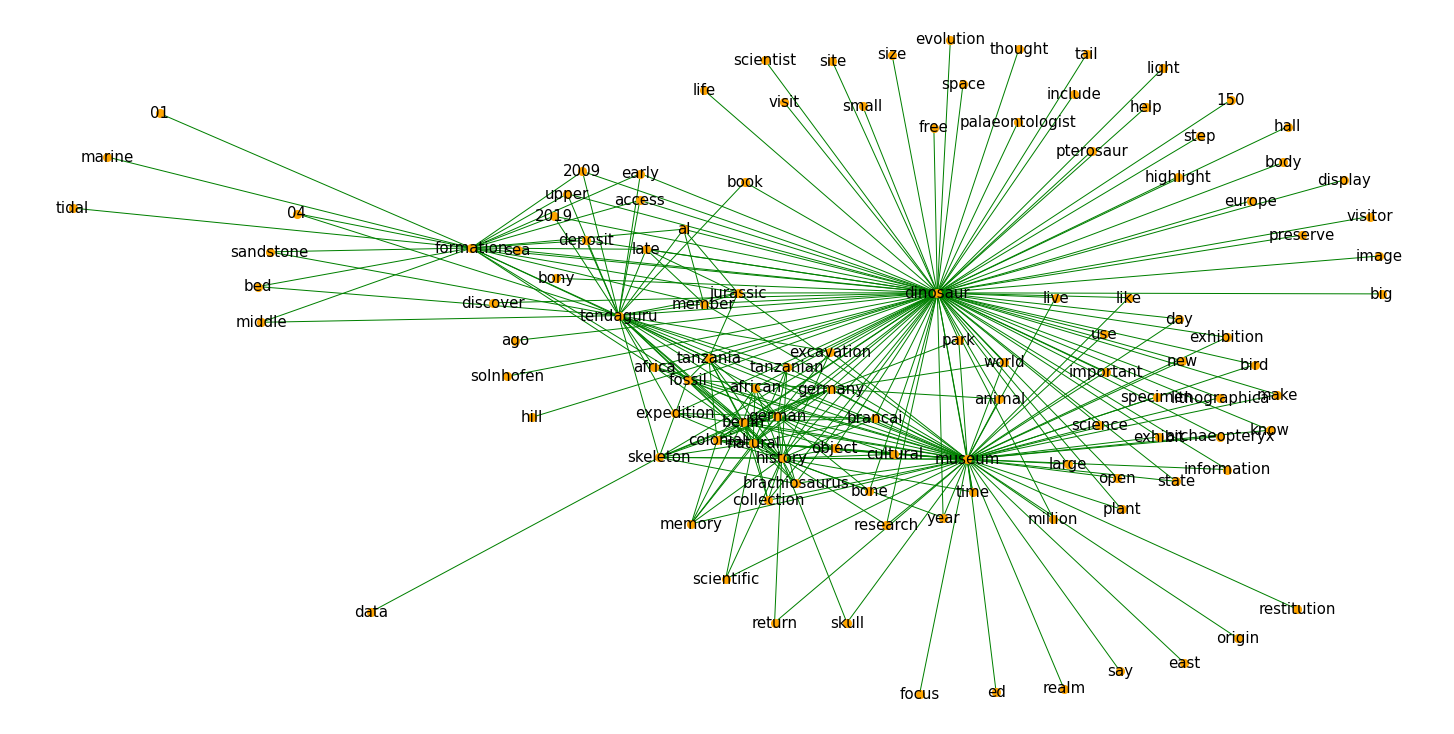

In [423]:
# great article had slides in it that were making my pictures ugly
slides_words = ['schedule', 'begin', 'end', 'slide']
df_text['lemma_text'] = df_text['lemma_text'].apply(lambda x: " ".join([item for item in x.split() if item not in slides_words]))
draw_network(df_text[:15], 'lemma_text', 1000, 'td_gc_content1000_15articles') #5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

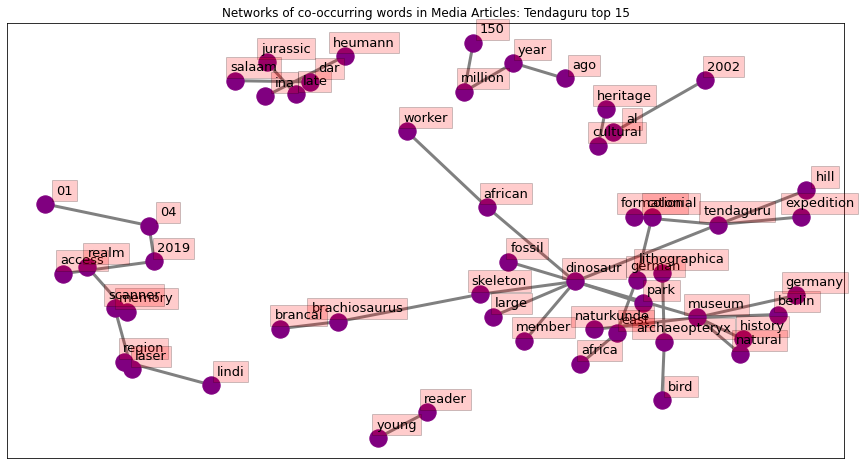

In [424]:
draw_cooccur_network(df_text[:15], 40,'lemma_text', 'Networks of co-occurring words in Media Articles: Tendaguru top 15')

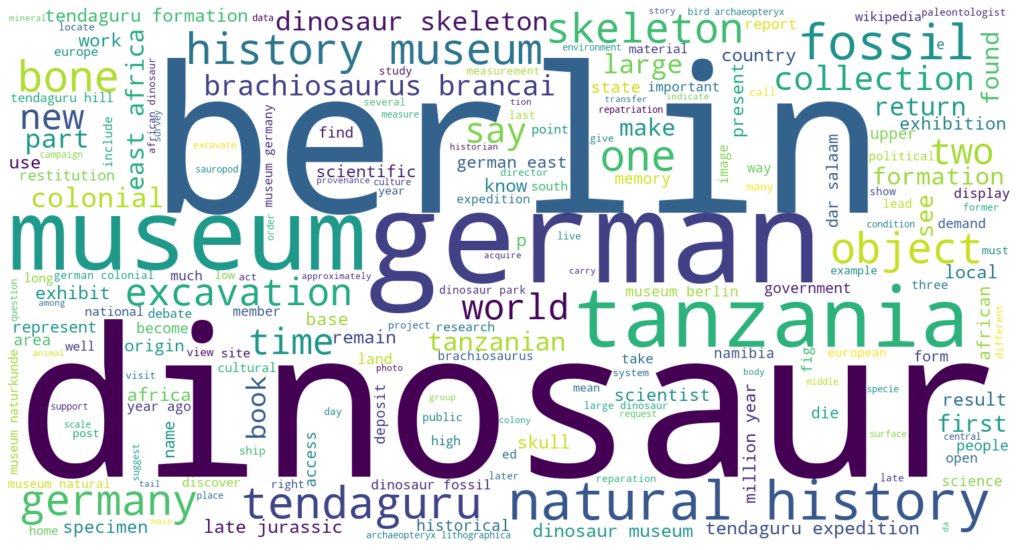

In [429]:
get_wordcloud(df_text[:15], 'lemma_text', 'td_content_wc_top15')

### All the articles

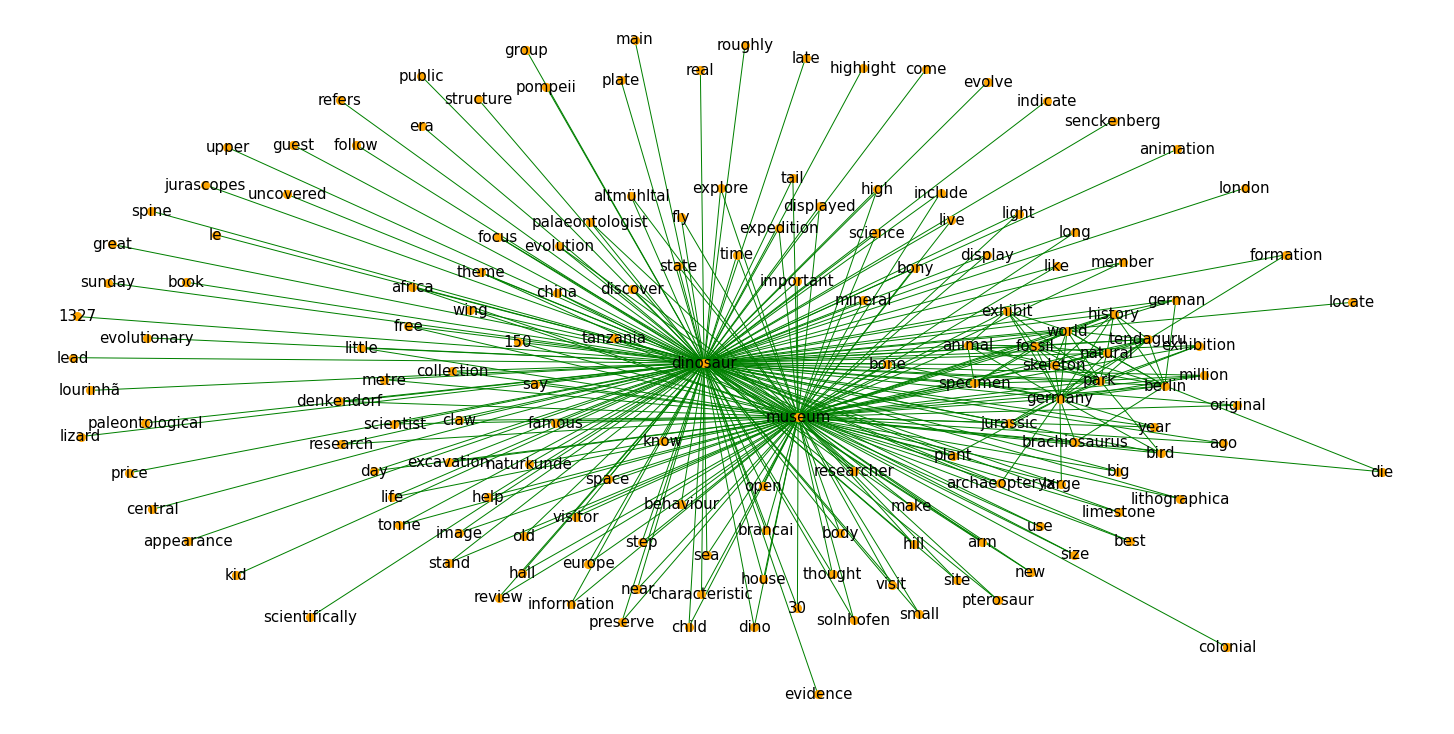

In [430]:
draw_network(df_text, 'lemma_text', 3300,'td_gc_content1000_allarticles' ) #5

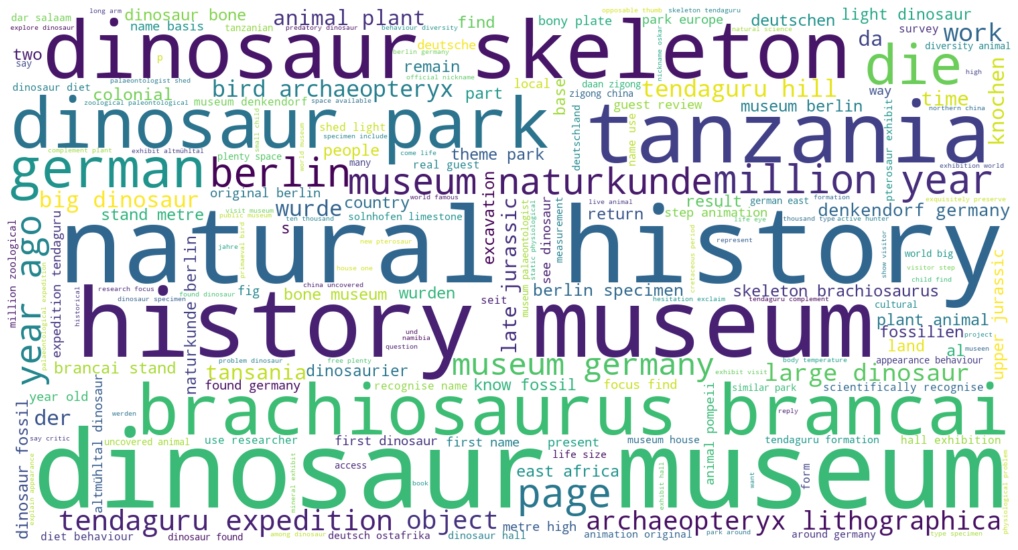

In [431]:
get_wordcloud(df_text, 'lemma_text', 'td_content_wc_all')

In [227]:
df_text.to_csv('tendaguru_google_text_manual_clean.csv')

### 2. Peoples vs mentions vs ethnicity - CSV list, bar chart: Pelonomi

In [ ]:
#this section requires Spacy
#!pip install spacy
#!python -m spacy download en_core_web_sm

#### Get names first

In [17]:
import spacy

In [18]:
from nltk.corpus import stopwords

In [19]:
def NER(text):
    """Takes in a string of text and returns a dataframe of all named entities
    
        Args:
            :param text: string, a string containing entire corpus
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    entities = []
    labels = []
    position_start = []
    position_end = []

    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)

    df = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

    return df

In [91]:
df_text.sample(10)

,title,link,text,html_date,text_len
12,"Countries demand their fossils back, forcing n...",https://www.sciencemag.org/news/2019/03/countr...,"Countries demand their fossils back, forcing n...",2019-03-28,6147
28,flower manase (@flowermanase) | Twitter,https://twitter.com/flowermanase?lang=en,JavaScript is not available. We’ve detected th...,2021-01-01,250
99,the most complete book library,http://qiomuedne.dns-stuff.com/,qiomuedne.dns-stuff.com is no way intended to ...,2019-01-01,434
0,Dinosaurs of Tendaguru - Wikipedia,https://en.wikipedia.org/wiki/Dinosaurs_of_Ten...,Dinosaurs of Tendaguru Dinosaurs of Tendaguru[...,2021-02-12,7819
27,Have you met... Nora Al-Badri & Nikolai Nelles...,https://bpigs.com/diaries/interviews/have-you-...,The Berlin-based artists Nora Al-Badri and Nik...,2017-09-29,17915
20,dinosaur museum germany - Purpose In Action,https://www.purpose-in-action.co.uk/radiative-...,dinosaur museum germany dinosaur museum german...,2021-01-01,27870
82,weber e 310 histoire geographie education civi...,http://weber-e-310.histoire-geographie-educati...,Download weber e 310 histoire geographie educa...,2020-01-01,2535
94,{Dоwnlоаd/Rеаd PDF Bооk} lirrazionale concetto...,http://09f681e586777204f1062d992ff5da5a.cdfad7...,Loading...,NaN,10
107,Museum Cooperation Between Africa And Europe E...,http://web.gulf.edu.sa/cgi-bin/content/viewer....,MUSEUM COOPERATION BETWEEN AFRICA AND EUROPE |...,1995-08-08,4492
19,Dinosaurs of Tendaguru and similar topics | Fr...,https://frankensaurus.com/Dinosaurs_of_Tendaguru,Topics similar to or like Dinosaurs of Tendagu...,2021-01-01,4413


In [92]:
#there is a couple of nans in here (8 articles in total) including two Japanese articles hahaha
df = df_text[~df_text['text'].isna()]
text = ''.join(x for x in df['text'])

In [93]:
stopwords_eng = stopwords.words('english')
tokenized_doc = text.split()
no_stopwords = " ".join([item for item in tokenized_doc if item not in stopwords_eng])  

In [94]:
len(no_stopwords)

526861

In [98]:
ner_df = NER(text[0:1000000])
ner_df2 = NER(text[1000000:2000000])
ner_df3 = NER(text[2000000:3000000])

In [99]:
ner_df4 = NER(text[3000000:4000000])
ner_df5 = NER(text[4000000:5000000])
ner_df6 = NER(text[5000000:6000000])

In [46]:
ner_df7 = NER(text[6000000:7000000])
ner_df8 = NER(text[7000000:8000000])
ner_df9 = NER(text[8000000:9000000])

In [47]:
ner_df10 = NER(text[9000000:10000000])
ner_df11 = NER(text[10000000:11000000])
ner_df12 = NER(text[11000000:12000000])

In [48]:
ner_df13 = NER(text[12000000:13000000])
ner_df14 = NER(text[13000000:14000000])

In [100]:
ner = pd.concat([ner_df, ner_df2, ner_df3, ner_df4, ner_df5, ner_df6])

In [101]:
ner['count'] = 1

In [102]:
ner = ner[(ner['Labels'] == 'PERSON')]

In [103]:
ner['Entities'] = ner['Entities'].astype(str)
ner = ner.groupby('Entities').agg('sum').reset_index().sort_values('count',ascending=False)

In [104]:
exl_list = ['Benin', 'British', 'Museums', 'Benin Bronze', 'Benin Bronzes', 'Museum', 'Tendaguru', 
            'Bone', 'Copyright ©', 'Dinosaurs']
ner = ner[~ner['Entities'].isin(exl_list)]
ner.head(40)

,Entities,Position_Start,Position_End,count
103,Archaeopteryx lithographica,15459383.0,15460382.0,37
959,Jurascopes,14718457.0,14718787.0,33
746,Giraffatitan,7570741.0,7571101.0,30
1408,Oskar,12220949.0,12221079.0,26
488,Dracula,9894786.0,9894940.0,22
1722,Tendaguru Hill,8091394.0,8091632.0,17
1375,No.71 Zhakoushan Rd.,7764775.0,7765115.0,17
1853,Werner E. M. Janensch,7535950.0,7536286.0,16
309,Charles Darwin,6234839.0,6235035.0,14
1673,Stegosaurus,6184391.0,6184545.0,14


In [105]:
ner[['Entities', 'count']].to_csv('../data_gc/td_media_people_mentions.csv')

I wrote to file here, started the ethnic env then read in the file and continued

In [106]:
import re

In [432]:
ner = pd.read_csv('../data_gc/td_media_people_mentions.csv', index_col=0)

In [433]:
ner['surname'] = ner['Entities'].apply(lambda x: clean_name(x, True))

In [434]:
remove_list = ['Benin', 'Twitter', 'Panther', 'Museum', 'Museums', 'Egypte', 'Nefertiti', 'Dendera', 
               'Egypt', 'Miocene', 'Verdun', 'Lithographica', 'Jurascopes', 'Giraffatitan', 'Hill',
               'Stegosaurus', 'Denkendorf', 'Brachiosaurus', 'wurde', 'jahre', 'Berlin', 'fossilien',
              'Welt', 'dner', 'Images', 'Salaam', 'Dracula', 'Tendaguru', 'Compsognathus','Hamburg',
              'antworten', 'model', 'tansania', 'kolonialismus','maji-maji-krieg', 'dinosaur', 'juravenator',
              'dinopolis', 'Museen', 'Munchehagen', 'skelett', 'lourinha']
for item in remove_list:
    ner = ner[~ner['surname'].str.contains(item.lower())]

#### Remove non names

In [435]:
ner = ner[~ner['surname'].str.contains("\\n")]
ner = ner[~ner['surname'].str.contains("\/")]
ner = ner[~ner['surname'].str.contains("\(")]
ner = ner[~ner['surname'].str.contains("\.")]
ner = ner[~ner['surname'].str.contains("\|")]
ner = ner[~ner['surname'].str.contains("\--")]
ner = ner[~ner['surname'].str.contains("\- ")]
ner = ner[~ner['surname'].str.contains("ii")]
ner = ner[~ner['surname'].str.contains("iv")]
ner['surname'] = ner['surname'].str.replace("'s'", '')
ner['has_nums'] = ner['surname'].apply(lambda x: len(re.findall('\d+', x)))
ner = ner[ner['has_nums'] ==0]
ner['no_words'] = ner['surname'].apply(lambda x: len(x.split()))
ner = ner[ner['no_words'] <=3]
ner['no_letters'] = ner['surname'].apply(lambda x: len(x))
ner = ner[ner['no_letters'] >1]

In [436]:
ner["surname"].replace({"macron’s": "macron"}, inplace=True)
ner["surname"].replace({"boheti": "buheti"}, inplace=True)

In [437]:
preds2 = ner.groupby('surname').agg('sum').reset_index()

In [438]:
preds2 = pred_wiki_ln(preds2, "surname")

In [439]:
preds2['african'] = preds2['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


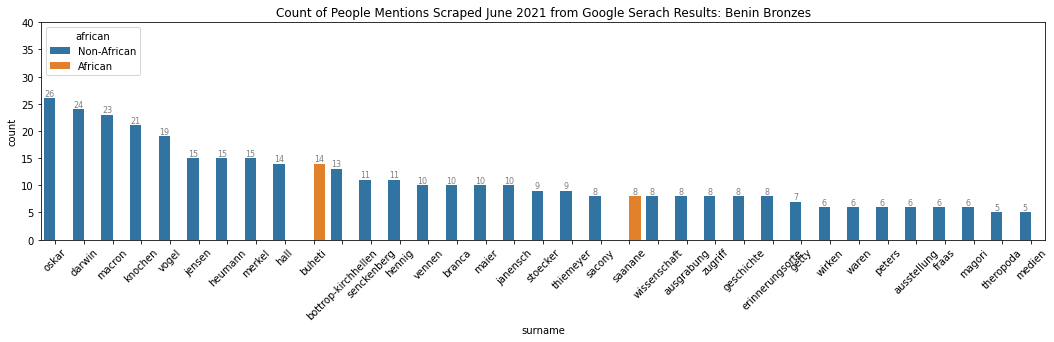

In [440]:
#manual fixes
for name in fix_list:
    preds2.loc[preds2['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Scraped June 2021 from Google Serach Results: Benin Bronzes')
g = sns.barplot(data=preds2.sort_values('count', ascending= False)[0:35], 
             x="surname", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,40) #To make space for the annotations
plt.savefig('../artefacts/td_gc_mentionsperperson.eps', format='eps')

In [443]:
preds2.sort_values('count', ascending = False).reset_index().to_csv('td_mentions.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


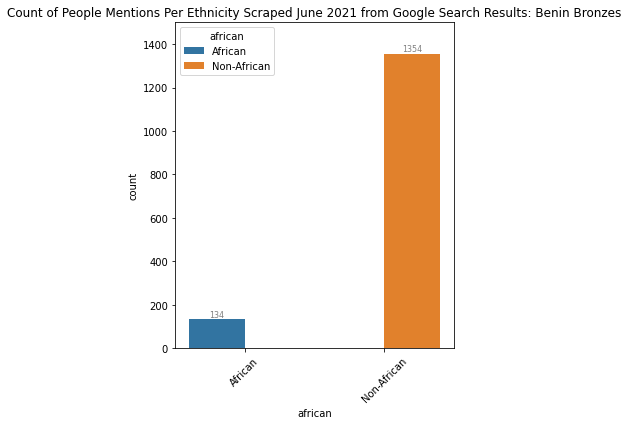

In [444]:
half = int(len(preds2)/2)
ratio = preds2.sort_values('count', ascending = False)[:half].groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Per Ethnicity Scraped June 2021 from Google Search Results: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,1500) #To make space for the annotations
plt.savefig('../artefacts/td_gc_mentionsperethnicity_half.eps', format='eps')

TODO: need to fix this because there are some times where only the surname is mentioned, need to group by on that before getting the ethnicity to get a proper representation of the numbers